In [5]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import numpy as np

In [ ]:
import pathlib
dataset_url = "https://drive.google.com/drive/folders/1vh8jUUWJVRao_3SK0hxBS9AK35E49nWL"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname="PlantVillage",
                                   untar=True)
data_dir = pathlib.Path(data_dir)

  16384/Unknown - 0s 0us/step

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/PlantVillage",
                                                 shuffle=True,
                                                   image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                  batch_size = BATCH_SIZE
                                                 )

Found 2152 files belonging to 3 classes.


In [3]:
! mv /content/drive/MyDrive/PlantVillage /content/PlantVillage

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!nvidia-smi

Wed Aug  3 06:13:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0]) #prints a tensor
  print(image_batch[0].numpy()) #prints a numpy
 

tf.Tensor(
[[[203. 200. 207.]
  [204. 201. 208.]
  [203. 200. 207.]
  ...
  [192. 191. 199.]
  [191. 190. 198.]
  [189. 188. 196.]]

 [[198. 195. 202.]
  [199. 196. 203.]
  [201. 198. 205.]
  ...
  [196. 195. 203.]
  [196. 195. 203.]
  [196. 195. 203.]]

 [[192. 189. 196.]
  [195. 192. 199.]
  [199. 196. 203.]
  ...
  [191. 190. 198.]
  [191. 190. 198.]
  [193. 192. 200.]]

 ...

 [[151. 148. 155.]
  [155. 152. 159.]
  [151. 148. 155.]
  ...
  [143. 140. 151.]
  [143. 140. 151.]
  [136. 133. 144.]]

 [[150. 147. 154.]
  [166. 163. 170.]
  [167. 164. 171.]
  ...
  [129. 126. 137.]
  [153. 150. 161.]
  [144. 141. 152.]]

 [[149. 146. 153.]
  [150. 147. 154.]
  [141. 138. 145.]
  ...
  [131. 128. 139.]
  [154. 151. 162.]
  [155. 152. 163.]]], shape=(256, 256, 3), dtype=float32)
[[[203. 200. 207.]
  [204. 201. 208.]
  [203. 200. 207.]
  ...
  [192. 191. 199.]
  [191. 190. 198.]
  [189. 188. 196.]]

 [[198. 195. 202.]
  [199. 196. 203.]
  [201. 198. 205.]
  ...
  [196. 195. 203.]
  [196. 19

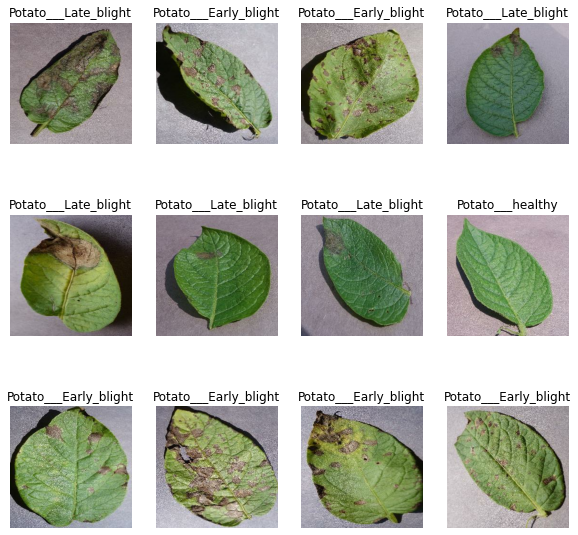

In [12]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [13]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds


In [20]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
# Using CNN to train the data

In [25]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')


])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [27]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
54/54 [==============================] - 23s 110ms/step - loss: 0.9052 - accuracy: 0.4936 - val_loss: 0.9083 - val_accuracy: 0.5625
Epoch 2/20
54/54 [==============================] - 4s 75ms/step - loss: 0.7554 - accuracy: 0.6273 - val_loss: 0.6754 - val_accuracy: 0.6823
Epoch 3/20
54/54 [==============================] - 4s 72ms/step - loss: 0.4511 - accuracy: 0.8084 - val_loss: 0.3628 - val_accuracy: 0.8542
Epoch 4/20
54/54 [==============================] - 4s 72ms/step - loss: 0.3369 - accuracy: 0.8646 - val_loss: 0.2778 - val_accuracy: 0.8906
Epoch 5/20
54/54 [==============================] - 4s 74ms/step - loss: 0.3537 - accuracy: 0.8571 - val_loss: 0.2897 - val_accuracy: 0.8750
Epoch 6/20
54/54 [==============================] - 4s 72ms/step - loss: 0.2859 - accuracy: 0.8889 - val_loss: 0.2013 - val_accuracy: 0.9219
Epoch 7/20
54/54 [==============================] - 4s 72ms/step - loss: 0.2217 - accuracy: 0.9080 - val_loss: 0.2627 - val_accuracy: 0.9010
Epoch 8/20


In [29]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 56ms/step - loss: 0.1145 - accuracy: 0.9612


In [30]:
scores

[0.1145140528678894, 0.9612069129943848]

In [31]:
history

In [32]:
history.params

{'epochs': 20, 'steps': 54, 'verbose': 1}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history['accuracy']

[0.49363425374031067,
 0.6273148059844971,
 0.8084490895271301,
 0.8645833134651184,
 0.8570601940155029,
 0.8888888955116272,
 0.9079861044883728,
 0.8859953880310059,
 0.921875,
 0.9224537014961243,
 0.9375,
 0.9438657164573669,
 0.9363425970077515,
 0.9247685074806213,
 0.9537037014961243,
 0.9623842835426331,
 0.9473379850387573,
 0.9658564925193787,
 0.9693287014961243,
 0.9652777910232544]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

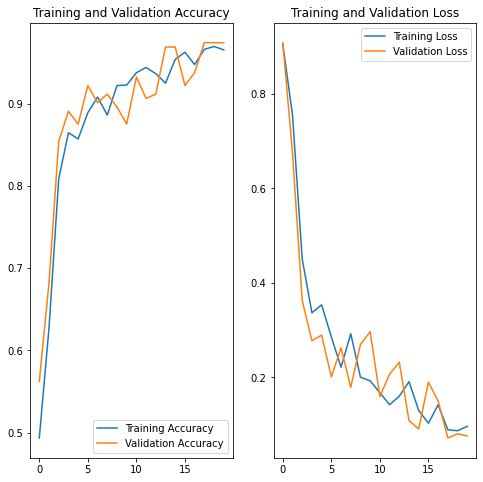

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


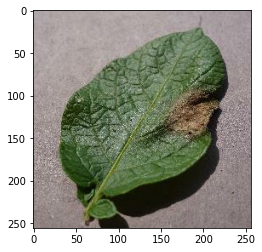

In [37]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [38]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

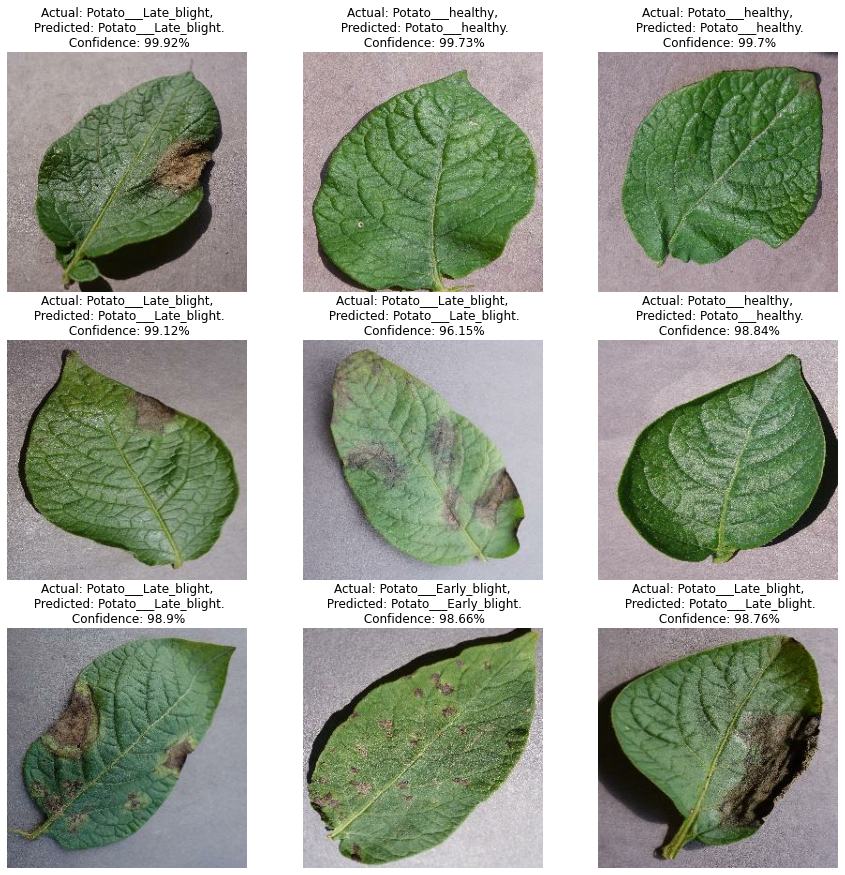

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
model_version = 'mv2'
model.save(f"/content/drive/MyDrive/models/{model_version}")



In [41]:
import os 
os.listdir("/content/drive/MyDrive/models")

['mv1', 'mv2']